# Binomial Mixture Model with Expectation-Maximization (EM) Algorithm


## Generating Data

We first generate some data points which are randomly drawn from a Binomial Mixture Model with two Binomial Distributions. Given $N_i$, the probability of $n_i$ is

$P(n_i | N_i, \Theta) = \sum_{k=1}^{2}\pi_k \mathrm{Bino}(n_i|N_i, \theta_k)$, 

where the Binomial Distribution is

$\mathrm{Bino}(n_i|N_i, \theta) = {N_i!\over n_i!(N_i-n_i)!} \theta^{n_i} (1-\theta)^{N_i-n_i}$,

and the sum of $\pi$'s is unity, i.e.

$\sum_{k=1}^{2} \pi_k = 1$

In [1]:
import numpy as np
import torch
from torch.distributions.binomial import Binomial

if torch.cuda.is_available():
    print("cuda is available")
    import torch.cuda as t
else:
    print("cuda is unavailable")
    import torch as t

cuda is unavailable


In [2]:
S = int(1e3)

# the theta's the two Binomial Distributions
theta_1 = 0.5
theta_2 = 0.3

# the probabilities, pi's, of the two Binomial Distributions
pi_1 = 0.7
pi_2 = 1.0 - pi_1

# the list of (Ni| i =1, 2, ..., S), uniformly drawn between low and high
N_ls_all = t.randint(low=10, high=20, size=(S,))
N_ls_all = N_ls_all.type(t.FloatTensor)

# the list of theta, each theta is either theta_1 or theta_2. The probability of theta_i is pi_i
theta_ls = t.FloatTensor(np.random.choice([theta_1,theta_2], size=S, p=[pi_1,pi_2]))

# the list of (ni | i=1,2 ...,S)
n_ls_all = Binomial(N_ls_all, theta_ls).sample()

Make some figures to get some visual impression of the dataset.

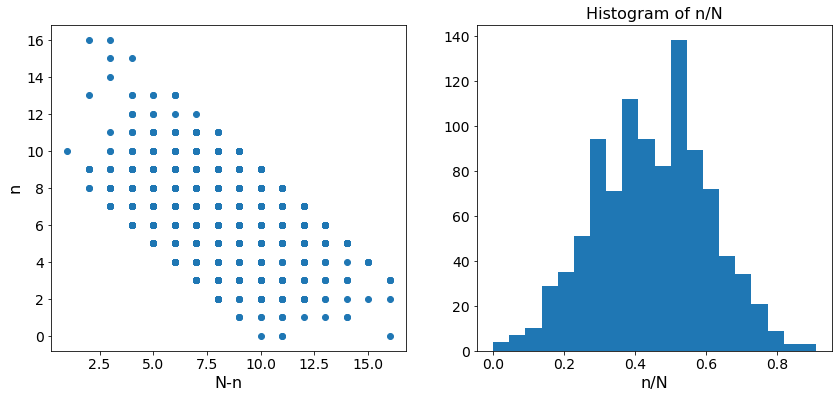

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline 

fig, axes = plt.subplots(1,2,figsize=(14,6))
axes[0].scatter(N_ls_all-n_ls_all, n_ls_all)
axes[0].set_xlabel("N-n",size=16)
axes[0].set_ylabel("n",size=16)
axes[0].tick_params(labelsize=14)

axes[1].hist(n_ls_all/N_ls_all, bins=20)
axes[1].set_xlabel("n/N", size=16)
axes[1].tick_params(labelsize=14)
axes[1].set_title("Histogram of n/N", size=16)
plt.show()

We split the dataset into train and validation. 

In [ ]:
# Split into train and validation sets
S = len(N_ls_all)
shuffled_indice = torch.randperm(S)
N_ls_shuffled = N_ls_all[shuffled_indice]
n_ls_shuffled = n_ls_all[shuffled_indice]

# percentage of train set.
train_frac = 0.7
train_index = int(0.7*S)
N_ls_train = N_ls_shuffled[0:train_index]
N_ls_valid = N_ls_shuffled[train_index:]
n_ls_train = n_ls_shuffled[0:train_index]
n_ls_valid = n_ls_shuffled[train_index:]

### Calculating the `log_likelihood` 

The `log_likelihood` is the log of the probability of the parameters, $\Theta$, given the observed data, `N_ls` and `n_ls`. It is defined below,

`log_likelihood` $= \ln(L(\Theta, {ni})) =\ln( P({ni} | \Theta)) = \sum_{i=1}^{S} \ln(\sum_{k=1}^{K} \pi_k * \mathrm{Binom}(n_i|N_i, \theta_k) )$

In [ ]:
# calculate log_likelihood using a method which supposes to avoid underflow or overflow in
# log_sum_exp = log(sum_{i=1}^{S} exp(bi)). When bi >> 1, overflow leads to log_sum_exp = infty
# When bi << -1, underflow leads to log_sum_exp = -infty.

def calc_logL(N_ls, n_ls, pi_list, theta_list):
    '''
    Input: N_ls is a [S] shape tensor = [N1, N2, ..., NS]
           n_ls is a [S] shape tensor = [n1, n2, ..., nS]
           pi_list is a [K] shape tensor = [pi_1, .., pi_K]
           theta_list is a [K] shape tensor = [theta_1, ..., theta_K]
    Output: log_likelihood of the parameters (pi and theta) given the observed data (N, n).
    '''
    S = len(N_ls)
    K = len(pi_list)

    # log_binom_mat has shape (S,K), element_{i,l} = log_Binomial(ni|Ni, theta_l)
    # log with natural base.
    log_binom_mat = Binomial(N_ls.reshape(S,1), theta_list.reshape(1,K)).log_prob(n_ls.reshape(S,1))

    # mean_log_binom, the mean value of all elements in log_binom_mat.
    c = torch.mean(log_binom_mat)

    # binom_mat has shape (S,K), element_{i,l} = Binomial(ni|Ni, theta_l)
    binom_mat = torch.exp(log_binom_mat - c)

    # log_likelihood = sum_{i=1}^{S} log(prob_i), this is a real number
    log_likelihood = S*c + torch.sum(torch.log(torch.matmul(binom_mat, pi_list)))

    return log_likelihood


### Calculating $P(z_i=m| n_i, \Theta_\mathrm{old})$

$P(z_i=m| n_i, \Theta_\mathrm{old}) = \left[\sum_{l=1}^{K} {\pi_{l,old}\over \pi_{m,old}}\left(\theta_{l,old}\over\theta_{m,old}\right)^{n_i}\left({1-\theta_{l,old}}\over{1-\theta_{m,old}}\right)^{N_i-n_i}\right]^{-1}$

We take advantage of the [broadcast](https://pytorch.org/docs/stable/notes/broadcasting.html) nature for torch tensors. Any torch math manipulations, except element-wise manipulations, would take action in a broadcast way as long as the tensors are broadcastable. Broadcasting does not make copy of the data on the memory and thus is very efficient and much more preferred to `for loop`.

In [ ]:
def calc_Posterior(N_ls, n_ls, pi_list, theta_list):
    '''
    Input: N_ls is a [S] shape tensor = [N1, N2, ..., NS]
           n_ls is a [S] shape tensor = [n1, n2, ..., nS]
           pi_list is a [K] shape tensor = [pi_1, .., pi_K]
           theta_list is a [K] shape tensor = [theta_1, ..., theta_K]
    Output: Posterior, a tensor with shape (K,S) and its element_{m,i} = P(zi=m|ni,Theta_old) which is
            the posterior probability of the i-th sample belonging to the m-th Binomial distribution.
    '''

    # shape = (K,K) with theta_ratio_{m,l} = theta_l/theta_m, m-th row, l-th column
    theta_ratio = torch.div(theta_list.reshape(1,K), theta_list.reshape(K,1))

    # shape = (K,K), element_{ml} = (1-theta_l)/(1-theta_m)
    unity_minus_theta_ratio = torch.div((1e0 - theta_list).reshape(1,K), (1e0 - theta_list).reshape(K,1))

    # shape = (K,K), element_{m,l} = (theta_l/theta_m) * [(1-theta_l)/(1-theta_m)]
    mixed_ratio = torch.mul(theta_ratio, unity_minus_theta_ratio)

    # shape = (K,K,S) with element_{m,l,i} = [(theta_l/theta_m)*(1-theta_l)/(1-theta_m)]^ni
    # its element won't be either 0 or infty no matther whether theta_l > or < theta_m
    mixed_ratio_pow = torch.pow(theta_ratio.reshape(K,K,1), n_ls)
    mixed_ratio_pow = torch.clamp(mixed_ratio_pow, min=0.0, max=1e15)

    # shape = (K,K,S) with element_{m,l,i} = [ (1-theta_l)/(1-theta_m) ]^(Ni-2ni)
    # its element may be infty if theta_l<<theta_m, or 0 if theta_l >> theta_m
    unity_minus_theta_ratio_pow = torch.pow(unity_minus_theta_ratio.reshape(K,K,1), N_ls-2.0*n_ls)
    unity_minus_theta_ratio_pow = torch.clamp(unity_minus_theta_ratio_pow, min=0.0, max=1e15)

    # In below, we multiply the element of mixed_ratio_pow and the element of unity_minus_theta_ratio_pow,
    # and there won't be nan caused by 0*infty or infty*0 because the element in mixed_ratio_pow won't be 0 or infty.
    # Thus we make sure there won't be nan in Posterior.

    # element-wise multiply, pow_tensor has shape(K,K,S), element_{m,l,i} = (theta_l/theta_m)^ni * [(1-theta_l)/(1-theta_m)]^(Ni-ni).
    # Note that torch.mul(a, b) would broadcast if a and b are different in shape & they are
    # broadcastable. If a and b are the same in shape, torch.mul(a,b) would operate element-wise multiplication.

    pow_tensor = torch.mul(mixed_ratio_pow, unity_minus_theta_ratio_pow)

    # pi_ratio has shape (K,K) with element_{m,l} = pi_l/pi_m
    pi_ratio = torch.div(pi_list.reshape(1,K), pi_list.reshape(K,1))

    # posterior probability tensor, Pzim = P(zi=m|ni,Theta_old)
    # shape (K,S), element_{m,i} = P(zi=m|ni,Theta_old)
    Posterior = torch.pow(torch.matmul(pi_ratio.reshape(K,1,K), pow_tensor), -1e0).reshape(K,S)

    return Posterior

### Update $\Theta \equiv \{(\pi_m, \theta_m)|m=1,2,...,K\}$ According to the EM Algorithm

The computational complexity of the EM Algorithm is $S\times K$ per iteration.

$\pi_m ={1\over S} \sum_{i=1}^{S} P(z_i=m| n_i, \Theta_{old})$

$\theta_m = {{\sum_{i=1}^{S} n_i P(z_i=m| n_i, \Theta_{old})}\over{\sum_{j=1}^{S} N_j P(z_j=m| n_j, \Theta_{old})}}$

In [ ]:
def calc_params(N_ls, n_ls, Posterior):
    '''
    Input: N_ls, tensor of shape [S]
           n_ls, tensor of shape [S]
           Posterior, tensor of shape (K,S)
    '''
    # update pi_list
    # torch.sum(tensor, n) sum over the n-th dimension of the tensor
    # e.g. if tensor'shape is (K,S) and n=1, the resulting tensor has shape (K,)
    # the m-th element is the sum_{i=1}^{S} tensor_{m,i}
    pi_list = torch.sum(Posterior,1)/len(N_ls)

    # update theta_list
    theta_list = torch.div(torch.matmul(Posterior, n_ls), torch.matmul(Posterior, N_ls))

    return pi_list, theta_list

We only want to train on the training set. So we make the following assignments.

In [ ]:
N_ls = N_ls_train
n_ls = n_ls_train

# Fitting the Data by a Binomial Mixture Model

The method would fit the parameters

$\Theta = \{ (\pi_k, \theta_k) | k=1, 2, ..., K\}$

We need to pre-set K. Here we set $K=2$. Of course, in reality we would not know the best $K$ to adopt. We will discuss how to choose $K$ after this section.


## Step 1: Initializing the parameters $\Theta$

We denote $\Theta$ by `params` in this code.

In [ ]:
# set K
K = 2
# choose a very small positive real number 
small_value = 1e-6

# initialize pi's, make sure that the sum of all pi's is unity
# pi is drawn from a Uniform distribution bound by [small_value, 1)
from torch.distributions.uniform import Uniform
pi_list = Uniform(low=small_value, high=1e0).sample([K-1])
pi_K = t.FloatTensor([1e0]) - pi_list.sum()
pi_list = torch.cat([pi_list, pi_K], dim=0)

# initialize theta's, make sure that each theta satisfies 0<theta<1
from torch.distributions.normal import Normal
theta_list = torch.clamp(Normal(loc=0.5, scale=0.3).sample(t.IntTensor([K])), min=small_value, max=1e0-small_value)

# combine all pi and theta into a list of tuples called `params`, which is the capital Theta in my article
# params has the shape of K rows x 2 columns
params = torch.stack([pi_list, theta_list], dim=1)

## Step 2: Setting Up Conditions for Stopping the Iteration

* Calculate the `log_likelihood`.
    
    
* Initialize the change of the `log_likelihood` named `delta_log_likelihood` and the iteration step `iter_step`.


* Set the lower bound for `delta_log_likelihood` named `tolerance`  and the upper bound for the `iter_step` named `max_step`.


* Define conditions for the iteration to continue. If either condition fails, the iteration stops.

In [ ]:
# calculate the initial log_likelihood
log_likelihood = calc_logL(N_ls, n_ls, pi_list, theta_list)

# initialize the change of log_likelihood named `delta_log_likelihood` and the iteration step called `iter_step`
delta_log_likelihood = torch.norm(log_likelihood)
iter_step = 0

# tolerance for the change of the log-likelihood
tolerance = 1e-6

# set the maximum steps for iteration, stop the iteration if the number of steps reaches `max_step` 
max_step = int(1e2)

# The iteration stops when either of the following two conditions is broken first
cond_likelihood = (delta_log_likelihood > tolerance)
cond_step = t.BoolTensor([iter_step < max_step])

## Step 3: Iteration using the EM Algorithm

In [ ]:
import time
start_time = time.time()

while cond_step & cond_likelihood:

    # posterior probability tensor, Pzim = P(zi=m|ni,Theta_old)
    # shape (K,S), element_{m,i} = P(zi=m|ni,Theta_old)
    Posterior = calc_Posterior(N_ls, n_ls, pi_list, theta_list)
    
    # calculate the new pi_list and theta_list
    pi_list_new, theta_list_new =  calc_params(N_ls, n_ls, Posterior)

    # calculate the new log_likelihood
    log_likelihood_new = calc_logL(N_ls, n_ls, pi_list_new, theta_list_new)
    
    # calculate the change of the log-likelihood
    delta_log_likelihood = torch.norm(log_likelihood_new - log_likelihood)
    
    # update params 
    pi_list = pi_list_new
    theta_list = theta_list_new
    
    # update log_likelihood
    log_likelihood = log_likelihood_new
    
    # increase iter_step by 1
    iter_step += 1

    # update the conditions for the while loop
    # cond_params = (delta_params > epsilon)
    cond_likelihood = (delta_log_likelihood > tolerance)
    cond_step = t.BoolTensor([iter_step < max_step])
    
    if iter_step % 1 == 0:
        print(f"Iteration {iter_step}:")
        print(f"delta_log_likelihood = {delta_log_likelihood}")
        print(f"log_likelihood ={log_likelihood}")
        params = torch.stack([pi_list, theta_list], dim=1)
        print(f"{params}")
    
print(f"used {time.time()-start_time}")

## Fitting the number of components, K

The EM Algorithm above fits a BMM model to the data with a preset K, the number of components. However, in reality, we usually do not know K. Therefore, we need to find an optimal K.

We look at three metrics. 

* `log_likelihood`: $\log L$, the probability of the parameters, $\Theta$, given the observed data set, {ni, Ni|i=1,..,S}.


* Akaike Information Criterion (AIC): AIC $= -{2\over S}\log L + {2 (2K+1)\over S}$, where $(2K+1)$ is the number of parameters in a BMM model.


* Bayesian Information Criterion (BIC): BIC $= -2\log L + (2K+1)\log S$.

The more complicated the model is, the more parameters, and thus greater $(2K+1)$. A more complicated model generally fits the data better and thus results in greater `log_likelihood`, $\log L$. However, a complicated model may overfit the data, meaning that it fits the training data set well but generalizes poorly to new data. Therefore, one should put some penalty on the complexity of the model, which is taken care of by both AIC and BIC. 

The following cell fits a number of BMM models on the training data sets with various values for $K$. The the three metrics above are calculated and stored in `logL_list`, `AIC_list`, `BIC_list`. Then the trained BMM models are applied to the validation set and calculate the corresponding metrics. The metrics are stored in `logL_val_list`, `AIC_val_list`, `BIC_val_list`.


In [ ]:
# ------------------- Initialization -------------------------------------
# Sample size
S = len(N_ls)
S_val = len(N_ls_valid)

K_list = range(2, 9)
params_list = []

logL_list = []
AIC_list = []
BIC_list = []

logL_val_list = []
AIC_val_list = []
BIC_val_list = []

# Set K, the number of Binomial distributions in the to-be-fitted mixture model
for K in K_list:

    '''
    Initialize theta_list and pi_list
    '''

    # list of n/N sorted in ascending order
    ratio_ls = np.sort(n_array/N_array)

    # reproducibility
    np.random.seed(seed=123)

    # pick K random integer indice, [index_1, ..., index_K]
    random_indice = np.sort(np.random.choice(len(ratio_ls),K))
    # theta are the ratio at the random indice, { ratio_ls[index_k] | k=1,2,...,K }
    theta_array = ratio_ls[random_indice]


    # the proportion of the midpoint of each pair of consecutive indice
    # (index_k + index_{k+1})/2/len(ratio_ls), for k=1,2,...,K-1
    acc_portion_ls = (random_indice[1:]+random_indice[:-1])/2.0/len(ratio_ls)
    acc_portion_ls = np.append(acc_portion_ls, 1.0)
    # initialize pi_list using the portions of indice
    pi_array = np.insert(acc_portion_ls[1:] - acc_portion_ls[:-1], obj=0, values=acc_portion_ls[0])

    print(f"initial theta's are {theta_array}")
    print(f"initial pi's are {pi_array}")
    print(f"sum of all pi's is {pi_array.sum()}.")

    # convert numpy arrays to torch tensors.
    theta_list = t.FloatTensor(theta_array)
    pi_list = t.FloatTensor(pi_array)
    print(f"theta_list is on device {theta_list.get_device()}")
    print(f"pi_list is on device {pi_list.get_device()}")

    # combine all pi and theta into a list of tuples called `params`, which is referred to by Theta as well
    # params has the shape of K rows x 2 columns
    params = torch.stack([pi_list, theta_list], dim=1)



    # ---------------Setting stop conditions for the EM-Algorithm iterations---------------
    '''
    Conditions for the EM-Algorithm Iteration to Continue.
    '''

    # calculate the initial log_likelihood
    log_likelihood = calc_logL(N_ls, n_ls, pi_list, theta_list)
    log_likelihood_init = log_likelihood
    print(f"Initial log_likelihood is {log_likelihood}")

    # initialize the change of log_likelihood named `delta_log_likelihood` and the iteration step called `iter_step`
    delta_log_likelihood = torch.abs(log_likelihood)
    iter_step = 0
    delta_params = torch.norm(params.reshape(2*K,))

    # tolerance for the change of the log-likelihood or the change of params, depending on
    # which condition you decide to use
    logL_eps = 1e-2
    param_eps = 1e-5
    # set the maximum steps for iteration, stop the iteration if the number of steps reaches `max_step`
    max_step = int(1e4)

    # we define 3 conditions:
    # the condition below is that "the log_likelihood are still changing much"
    if torch.isnan(delta_log_likelihood) :
        cond_likelihood = True
    else:
        cond_likelihood = (torch.abs(delta_log_likelihood) > logL_eps)
    # the condition below is that "the iteration steps have not exceeded max_step"
    cond_step = t.BoolTensor([iter_step < max_step])
    # the condition below is that "the params are still changing much"
    cond_params = (delta_params >param_eps)



    # -------------- Iteration Loop -------------------------------------------------------
    '''
    EM-Algorithm Iterations
    '''
    import time
    start_time = time.time()

    # the second condition below may be either `cond_likelihood` or `cond_params`
    while cond_step & cond_params:

        # posterior probability tensor, Pzim = P(zi=m|ni,Theta_old)
        # shape (K,S), element_{m,i} = P(zi=m|ni,Theta_old)
        Posterior = calc_Posterior(N_ls, n_ls, pi_list, theta_list)

        # print(f"Does Posterior contain nan? {torch.isnan(Posterior).any()}")

        # calculate the new pi_list and theta_list
        pi_list_new, theta_list_new =  calc_params(N_ls, n_ls, Posterior)
        params_new = torch.stack([pi_list_new, theta_list_new], dim=1)

        # calculate the new log_likelihood
        log_likelihood_new = calc_logL(N_ls, n_ls, pi_list_new, theta_list_new)

        # calculate the change of the log-likelihood
        delta_log_likelihood = log_likelihood_new - log_likelihood

        # calculate the change of params
        delta_params = torch.norm(params_new.reshape(2*K,)-params.reshape(2*K,))

        # update params
        pi_list = pi_list_new
        theta_list = theta_list_new
        params = params_new

        # update log_likelihood
        log_likelihood = log_likelihood_new

        # increase iter_step by 1
        iter_step += 1

        # update the conditions for the while loop

        if torch.isnan(delta_log_likelihood) :
            cond_likelihood = True
        else:
            cond_likelihood = (torch.abs(delta_log_likelihood) > logL_eps)

        cond_step = t.BoolTensor([iter_step < max_step])
        cond_params = (delta_params > param_eps)

        # if iter_step % 5 == 0:
        #     print(f"Iteration {iter_step}:")
        #     print(f"logL = {log_likelihood:.6f}")
        #     # print(f"logL - logL_init = {log_likelihood - log_likelihood_init}")
        #     print(f"delta_logL = {delta_log_likelihood:.6f}")
        #     print(f"delta_params = {delta_params:.6f}")
        #     print(f"{params}")

    # calculate Akaike Information Criterion (AIC)
    AIC = -2.0/float(S)*log_likelihood + 2.0*(2.0*float(K)+1.0)/float(S)

    # Bayesian Information Criterion
    BIC = -2.0*log_likelihood + np.log(float(S))*(2.0*float(K)+1.0)

    #  calculate metrics for the validation sets
    log_likelihood_val = calc_logL(N_ls_valid, n_ls_valid, pi_list, theta_list)
    AIC_val = -2.0/float(S_val)*log_likelihood_val + 2.0*(2.0*float(K)+1.0)/float(S_val)
    BIC_val = -2.0*log_likelihood_val + np.log(float(S_val))*(2.0*float(K)+1.0)

    print(f"used {time.time()-start_time} seconds.")
    print("Final Results:")
    print(f"Iteration {iter_step}:")
    print(f"logL = {log_likelihood:.6f}")
    # print(f"logL - logL_init = {log_likelihood - log_likelihood_init}")
    print(f"delta_log_likelihood = {delta_log_likelihood:.6f}")
    print(f"delta_params = {delta_params:.6f}")
    params = torch.stack([pi_list, theta_list], dim=1)
    print(f"{params}")
    print(f"log_binom_min, max, mean = {log_binom_minmaxmean(N_ls, n_ls, pi_list, theta_list)}")
    print(f"Akaike Information Criterion (AIC) = {AIC:.6f}")
    print(f"Bayesian Information Criterion (BIC) = {BIC:.6f}")

    logL_list.append(log_likelihood)
    AIC_list.append(AIC)
    BIC_list.append(BIC)
    params_list.append(params)

    logL_val_list.append(log_likelihood_val)
    AIC_val_list.append(AIC_val)
    BIC_val_list.append(BIC_val)
